# Step 1. Load the  dataset and check basic information

In [9]:
import pandas as pd

# 14 column names including the first empty column
columns = [
    'Empty', 'Retailer', 'Retailer ID', 'Invoice Date', 'Region', 'State', 'City',
    'Product', 'Price per Unit', 'Units Sold', 'Total Sales',
    'Operating Profit', 'Operating Margin', 'Sales Method'
]

# Load Excel and skip first 4 rows (title/empty rows)
df = pd.read_excel(
    r"C:\Users\neeno\Downloads\Adidas US Sales Datasets.xlsx",
    header=None,  # no header, we will assign manually
    skiprows=4
)

# Assign column names and drop the empty column
df.columns = columns
df = df.drop(columns=['Empty'])

# Keep only relevant columns
df = df[['Invoice Date', 'Total Sales']]

# Drop rows with missing values
df = df.dropna(subset=['Invoice Date', 'Total Sales'])

# Convert Invoice Date to datetime (coerce errors)
df['Invoice Date'] = pd.to_datetime(df['Invoice Date'], errors='coerce')

# Drop rows where datetime conversion failed
df = df.dropna(subset=['Invoice Date'])

#Ensure 'Total Sales' is numeric
df['Total Sales'] = pd.to_numeric(df['Total Sales'], errors='coerce')
df = df.dropna(subset=['Total Sales'])

# Sort by date
df = df.sort_values('Invoice Date')
df.set_index('Invoice Date', inplace=True)

# Check first 5 rows
df.head()


C:\Users\neeno\AppData\Local\Temp\ipykernel_22448\1353804578.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Invoice Date'] = pd.to_datetime(df['Invoice Date'], errors='coerce')


,Total Sales
Invoice Date,
2020-01-01,600000.0
2020-01-01,206250.0
2020-01-01,4399.0
2020-01-01,15792.0
2020-01-01,13056.0


In [11]:
# 🔟 Aggregate monthly totals
ts_data = df.resample('M').sum()

# 1️⃣1️⃣ Optional: create month period for plotting
ts_data['Month'] = ts_data.index.to_period('M')

# 1️⃣2️⃣ Compute moving averages
ts_data['MA_3'] = ts_data['Total Sales'].rolling(window=3).mean()
ts_data['MA_6'] = ts_data['Total Sales'].rolling(window=6).mean()

# ✅ Check final DataFrame
print(ts_data.dtypes)
print(ts_data.head())

Total Sales      float64
Month          period[M]
MA_3             float64
MA_6             float64
dtype: object
              Total Sales    Month          MA_3  MA_6
Invoice Date                                          
2020-01-31     16253746.0  2020-01           NaN   NaN
2020-02-29     14997988.0  2020-02           NaN   NaN
2020-03-31     17660577.0  2020-03  1.630410e+07   NaN
2020-04-30     24607006.0  2020-04  1.908852e+07   NaN
2020-05-31     16918014.0  2020-05  1.972853e+07   NaN


C:\Users\neeno\AppData\Local\Temp\ipykernel_22448\3099286350.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_data = df.resample('M').sum()


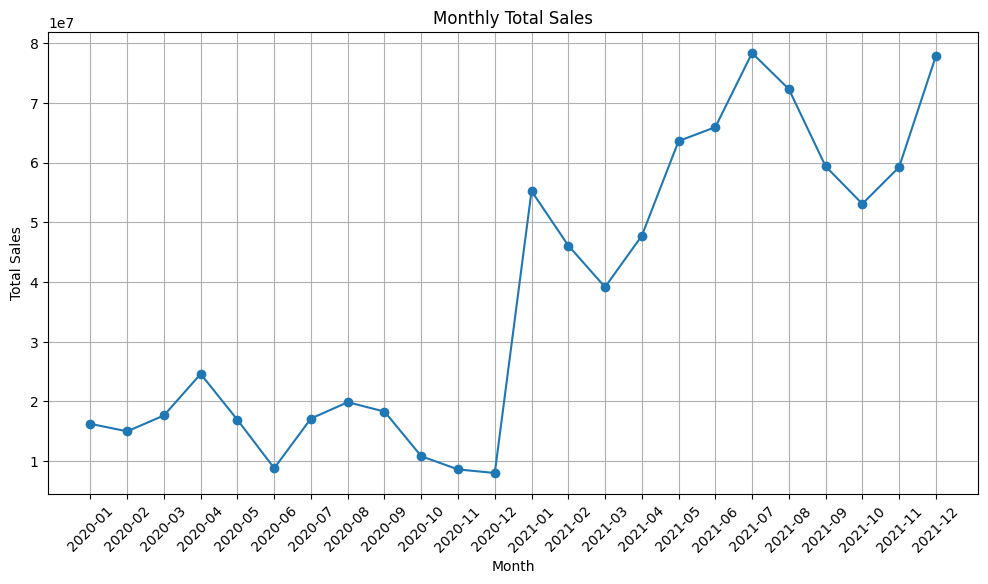

In [12]:
# Plot monthly sales
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(monthly_sales['Month'].astype(str), monthly_sales['Total Sales'], marker='o')
plt.title('Monthly Total Sales')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


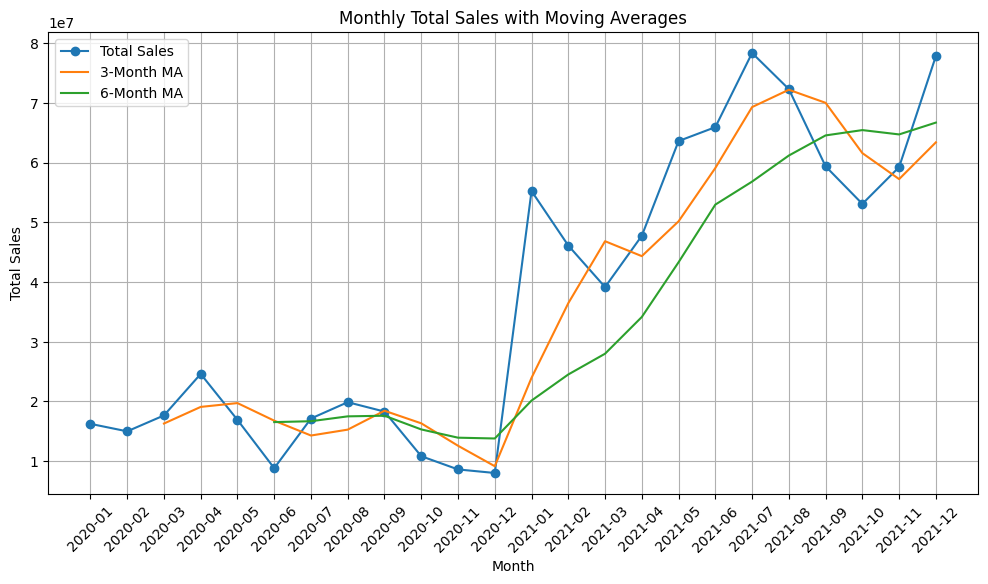

In [13]:
# Moving Average 
# 3-month moving average
monthly_sales['MA_3'] = monthly_sales['Total Sales'].rolling(window=3).mean()

# 6-month moving average
monthly_sales['MA_6'] = monthly_sales['Total Sales'].rolling(window=6).mean()

# Plot
plt.figure(figsize=(12,6))
plt.plot(monthly_sales['Month'].astype(str), monthly_sales['Total Sales'], marker='o', label='Total Sales')
plt.plot(monthly_sales['Month'].astype(str), monthly_sales['MA_3'], label='3-Month MA')
plt.plot(monthly_sales['Month'].astype(str), monthly_sales['MA_6'], label='6-Month MA')
plt.title('Monthly Total Sales with Moving Averages')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


In [15]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(ts_data['Total Sales'], order=(1,1,1))  # tune (p,d,q) if needed
arima_result = arima_model.fit()

# Forecast next 6 months
arima_forecast = arima_result.forecast(steps=6)
print(arima_forecast)


2022-01-31    7.534381e+07
2022-02-28    7.421258e+07
2022-03-31    7.369482e+07
2022-04-30    7.345785e+07
2022-05-31    7.334939e+07
2022-06-30    7.329975e+07
Freq: ME, Name: predicted_mean, dtype: float64


In [16]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

hw_model = ExponentialSmoothing(ts_data['Total Sales'], trend='add', seasonal='add', seasonal_periods=12)
hw_result = hw_model.fit()

hw_forecast = hw_result.forecast(6)
print(hw_forecast)


2022-01-31    1.166255e+08
2022-02-28    1.096236e+08
2022-03-31    1.037453e+08
2022-04-30    1.109522e+08
2022-05-31    1.225554e+08
2022-06-30    1.244084e+08
Freq: ME, dtype: float64


In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Create lag features
ts_data['lag_1'] = ts_data['Total Sales'].shift(1)
ts_data['lag_2'] = ts_data['Total Sales'].shift(2)
ts_data = ts_data.dropna()

X = ts_data[['lag_1', 'lag_2', 'MA_3', 'MA_6']]
y = ts_data['Total Sales']

tscv = TimeSeriesSplit(n_splits=3)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)

print("Random Forest Predictions:", y_pred_rf)


Random Forest Predictions: [74070781.87 70018225.71 67041884.48 69196523.03]


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Scale
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(ts_data[['Total Sales']])

# Create sequences
def create_sequences(data, seq_length=3):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_seq, y_seq = create_sequences(scaled_data, seq_length=3)
X_seq = X_seq.reshape((X_seq.shape[0], X_seq.shape[1], 1))

# LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(X_seq.shape[1], 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.fit(X_seq, y_seq, epochs=50, batch_size=8, verbose=0)

# Forecast next 6 months using last sequence
last_seq = scaled_data[-3:].reshape((1,3,1))
lstm_forecast_scaled = []
for _ in range(6):
    next_val = lstm_model.predict(last_seq, verbose=0)[0,0]
    lstm_forecast_scaled.append(next_val)
    last_seq = np.append(last_seq[:,1:,:], [[[next_val]]], axis=1)

lstm_forecast = scaler.inverse_transform(np.array(lstm_forecast_scaled).reshape(-1,1))
print(lstm_forecast)


[[61404864.]
 [64293264.]
 [66067176.]
 [62545396.]
 [63065128.]
 [62804516.]]


In [19]:
# Suppose last 6 months for evaluation
test_size = 6
ts_test = ts_data[-test_size:]


In [24]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

#Step 2: Generate predictions

#⃣ Moving Average

y_pred_ma = ts_data['Total Sales'].rolling(window=3).mean().iloc[-test_size:].values
next_month_ma = ts_data['MA_3'].iloc[-1]

#(You can also use the last MA value repeated if you want a pure forecast.)

#⃣ ARIMA

y_pred_arima = arima_result.forecast(steps=test_size)
arima_forecast = arima_result.forecast(steps=6)

#⃣ Holt-Winters

y_pred_hw = hw_result.forecast(test_size)
hw_forecast = hw_result.forecast(6)


#⃣ Random Forest

# Create lag & MA features for last test_size points
X_test = ts_data[['lag_1', 'lag_2', 'MA_3', 'MA_6']].iloc[-test_size:]
y_pred_rf = rf.predict(X_test)
last_row = ts_data.iloc[-1]
second_last_row = ts_data.iloc[-2]
X_next = pd.DataFrame({
    'lag_1': [last_row['Total Sales']],
    'lag_2': [second_last_row['Total Sales']],
    'MA_3': [ts_data['MA_3'].iloc[-1]],
    'MA_6': [ts_data['MA_6'].iloc[-1]]
})
rf_forecast = rf.predict(X_next)
#⃣ LSTM

from sklearn.preprocessing import MinMaxScaler

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(ts_data[['Total Sales']])

# Sequence length for LSTM
seq_length = 3  # same as used during LSTM training
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_seq, y_seq = create_sequences(scaled_data, seq_length)
X_seq = X_seq.reshape((X_seq.shape[0], X_seq.shape[1], 1))  # [samples, timesteps, features]

# Define LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_seq.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_seq, y_seq, epochs=50, batch_size=8, verbose=0)

# Forecast last test_size points
test_size = 6
last_seq = scaled_data[-seq_length:]  # last seq_length points
lstm_preds = []

for _ in range(test_size):
    seq_input = last_seq.reshape((1, seq_length, 1))
    pred = model.predict(seq_input, verbose=0)
    lstm_preds.append(pred[0,0])
    last_seq = np.append(last_seq[1:], pred[0,0]).reshape(-1,1)

# Scale back to original values
y_pred_lstm = scaler.inverse_transform(np.array(lstm_preds).reshape(-1,1)).flatten()
# Print next month forecast
# ------------------------
print("Next month forecasts:")
print("Moving Average:", next_month_ma)
print("ARIMA:", arima_forecast.values)
print("Holt-Winters:", hw_forecast.values)
print("Random Forest:", rf_forecast[0])
print("LSTM:", lstm_forecast[0][0])

# ------------------------



Next month forecasts:
Moving Average: 63375078.00000001
ARIMA: [75343810.9670963  74212576.21179612 73694821.63288933 73457850.6569509
 73349391.46465217 73299750.80149706]
Holt-Winters: [1.16625514e+08 1.09623626e+08 1.03745330e+08 1.10952223e+08
 1.22555378e+08 1.24408391e+08]
Random Forest: 73115181.67
LSTM: 61404864.0


In [26]:
# Evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_true = ts_test['Total Sales'].values

models = {
    "Moving Average": y_pred_ma,
    "ARIMA": y_pred_arima,
    "Holt-Winters": y_pred_hw,
    "Random Forest": y_pred_rf,
    "LSTM": y_pred_lstm
}

metrics = []

for name, y_pred in models.items():
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    metrics.append([name, rmse, mae, r2])

metrics_df = pd.DataFrame(metrics, columns=['Model', 'RMSE', 'MAE', 'R²'])
print("\nComparison of models:")
print(metrics_df)


Comparison of models:
            Model          RMSE           MAE         R²
0  Moving Average  8.943514e+06  7.458348e+06   0.180239
1           ARIMA  1.192544e+07  9.711024e+06  -0.457539
2    Holt-Winters  4.892275e+07  4.796755e+07 -23.529718
3   Random Forest  1.042140e+07  8.798419e+06  -0.113071
4            LSTM  1.216252e+07  9.811768e+06  -0.516065


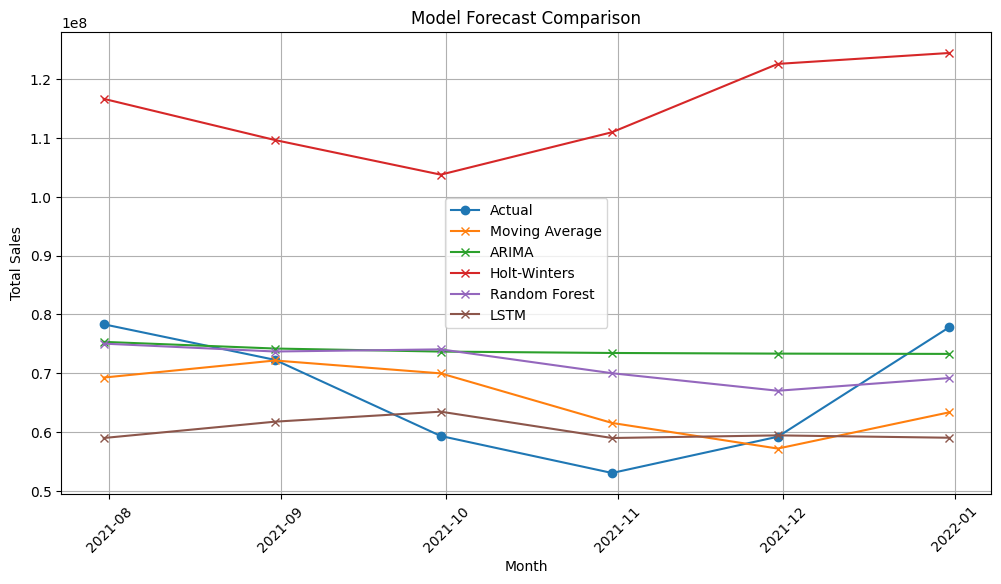

In [27]:
#Step 4: Optional Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(ts_test.index, y_true, marker='o', label='Actual')
for name, y_pred in models.items():
    plt.plot(ts_test.index, y_pred, marker='x', label=name)
plt.title('Model Forecast Comparison')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()